## Modeling
### Class Definition:
`ImbalancedBinaryCVSplit`: Split imbalanced binary target data set into N splits of balanced Test Sets to be used for model training and tested with X% of original data set, also imbalanced.

### Import libs

In [63]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    log_loss,
    RocCurveDisplay)
from sklearn.utils import shuffle
from tqdm.keras import TqdmCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
import tensorflow as tf

# Plotting settings
sns.set_style("darkgrid")
sns.set_context("paper")

# Random seeds for reproducibility
random_state = 42
np.random.seed(random_state)
random.seed(random_state)


### Function definition

In [2]:
def remove_outliers(X, y, random_state=random_state):
    out = IsolationForest(random_state=random_state)
    out_pred = out.fit_predict(X)
    X = X[out_pred == 1]
    y = y.loc[X.index]
    return X, y

### Class Definition

In [30]:
class LogScaler():
    def __init__(self):
        pass

    def fit_transform(self, X):
        log = np.log1p(X)
        log_mean = np.mean(log, axis=0)
        X = log - log_mean
        return X
    
    def transform(self, X):
        log = np.log1p(X)
        log_mean = np.mean(log, axis=0)
        X = log - log_mean
        return X

## Data Loading

In [49]:
# Load data
test = pd.read_csv('../../../Data/Raw/test.csv')
train = pd.read_csv('../../../Data/Raw/train.csv')
greeks = pd.read_csv('../../../Data/Raw/greeks.csv')

# Remove spaces from column names
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

# Drop ID column
train = train.drop(columns='Id')
test = test.drop(columns='Id')
greeks = greeks.drop(columns='Id')

# Remove rows with less than 1% missing values
train_missing = train.isnull().sum()
missing_cols = train_missing[train_missing > 0].index.tolist()
missing_cols.remove('BQ')
missing_cols.remove('EL')

# Get indexes of rows with missing values and drop them from train and greeks data sets
idx_missing = train[missing_cols][train[missing_cols].isnull().any(axis=1)].index
train = train.drop(idx_missing, axis=0).reset_index(drop=True)
greeks = greeks.drop(idx_missing, axis=0).reset_index(drop=True)

# Define features and target
X = train.drop(columns='Class')
y = train['Class']

# Encode categorical features
le = LabelEncoder()
X['EJ'] = le.fit_transform(X['EJ'])
test['EJ'] = le.transform(test['EJ'])

### Define balanced log loss score

Submissions are evaluated using a balanced logarithmic loss. The overall effect is such that each class is roughly equally important for the final score.

Each observation is either of class 0 or of class 1. For each observation, you must submit a probability for each class. The formula is then:

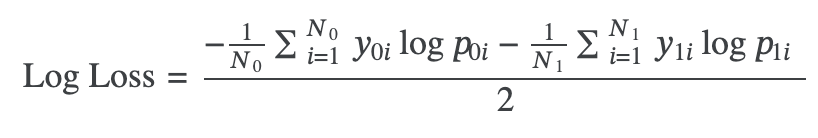

where (N_{c}) is the number of observations of class (c), (\log) is the natural logarithm, (y_{c i}) is 1 if observation (i) belongs to class (c) and 0 otherwise, (p_{c i}) is the predicted probability that observation (i) belongs to class (c).

The submitted probabilities for a given row are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, each predicted probability 𝑝
 is replaced with max(min(𝑝,1−10−15),10−15).

In [4]:
def balanced_logloss(y_true, y_score):
    """
    Calculates balanced logloss.
    """
    if len(y_score.shape) == 1 or (len(y_score.shape) == 2 and y_score.shape[-1] == 1):
        y_score = np.hstack((1 - y_score, y_score))

    y_true = np.array(y_true)
    y_score = np.array(y_score)
    y_score = y_score / y_score.sum(axis=1)[:, None]
    y_score = np.clip(y_score, 1e-15, 1 - 1e-15)

    nc = np.bincount(y_true)

    y_0 = np.array([1 if i == 0 else 0 for i in y_true])
    y_1 = np.array([1 if i == 1 else 0 for i in y_true])
    
    if nc[0] > 0:
        log_loss_0 = - (1 * np.sum(y_0 * np.log(y_score[:, 0]))) / nc[0]
    else:
        log_loss_0 = 0
    if nc[1] > 0:
        log_loss_1 = - (1 * np.sum(y_1 * np.log(y_score[:, 1]))) / nc[1]
    else:
        log_loss_1 = 0
        
    balanced_logloss = (log_loss_0 + log_loss_1) / 2
    return balanced_logloss


In [5]:
def balanced_logloss_val(y_true, y_score):
    """
    Calculates balanced logloss.
    """
    print('y_pred', y_score.__abs__)
    print('y_true shape:', y_true.shape)
    print('y_pred shape:', y_score.shape)
    print('y_pred dtype:', y_score.dtype)
    print(help(y_score))
    if len(y_score.shape) == 1 or (len(y_score.shape) == 2 and y_score.shape[-1] == 1):
        y_score = np.hstack((1 - y_score, y_score))

    y_true = np.array(y_true)
    y_score = np.array(y_score)
    y_score = y_score / y_score.sum(axis=1)[:, None]
    y_score = np.clip(y_score, 1e-15, 1 - 1e-15)

    nc = np.bincount(y_true)

    y_0 = np.array([1 if i == 0 else 0 for i in y_true])
    y_1 = np.array([1 if i == 1 else 0 for i in y_true])

    balanced_logloss = (-1 / nc[0] * np.sum(y_0 * np.log(y_score[:, 0])) - 1 / nc[1] * np.sum(y_1 * np.log(y_score[:, 1]))) / 2
    return balanced_logloss


### Build First Neural Network Model

0epoch [00:00, ?epoch/s]

Balanced Log Loss score: 0.5271
Accuracy: 87.80%
Precision: 68.42%
Recall: 59.09%
F1: 63.41%
ROC AUC: 89.87%


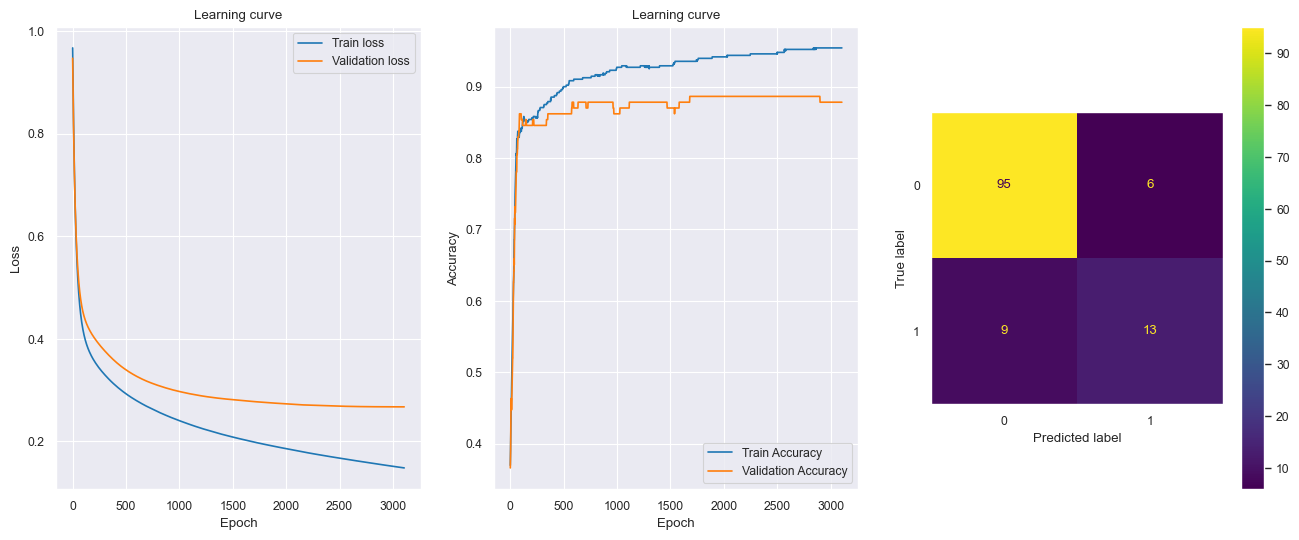

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

# Impute missing values
knn_imputer = KNNImputer(n_neighbors=5)
X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# Remove outliers
X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

# Scale features
scaler = LogScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# PCA
pca = PCA(n_components=0.85, random_state=random_state)
X_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
X_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)

# Neural Network Architecture
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile Neural Network
opt = SGD(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Callbacks
pgr_bar = TqdmCallback(verbose=0)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train Neural Network
history = model.fit(X_train, y_train, epochs=10000, batch_size=32, callbacks=[es, pgr_bar], verbose=0, validation_data=(X_test, y_test))

# Evaluate Neural Network
y_score = model.predict(X_test, verbose=0)
y_pred = np.where(y_score > 0.5, 1, 0)
score1 = balanced_logloss(y_test, y_score)
print(f'Balanced Log Loss score: {score1:.4f}')
print(f'Accuracy: {accuracy_score(y_test, y_pred) * 100 :.2f}%')
print(f'Precision: {precision_score(y_test, y_pred) * 100 :.2f}%')
print(f'Recall: {recall_score(y_test, y_pred) * 100 :.2f}%')
print(f'F1: {f1_score(y_test, y_pred) * 100 :.2f}%')
print(f'ROC AUC: {roc_auc_score(y_test, y_score) * 100 :.2f}%')

# Plot learning curves
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

plt.subplot(131)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Learning curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot(133)
ConfusionMatrixDisplay(cm).plot(ax=ax)
plt.grid(False)
plt.show()


In [37]:
test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)
test_pca = pd.DataFrame(pca.transform(test_scaled), index=test_scaled.index)
test_score = model.predict(test_pca, verbose=0)
test_score

array([[0.10403878],
       [0.10403878],
       [0.10403878],
       [0.10403878],
       [0.10403878]], dtype=float32)

### Split Train set into 5 K-Folds to balance classes 

Fold 0 Init 0 Balanced Log Loss: 0.5502
Fold 0 Init 1 Balanced Log Loss: 0.4783
Fold 0 Init 2 Balanced Log Loss: 0.6077
Fold 0 Init 3 Balanced Log Loss: 0.7793
Fold 0 Init 4 Balanced Log Loss: 0.5003
Fold 0 Balanced Log Loss: 0.4783
Fold 0 Accuracy: 72.09%


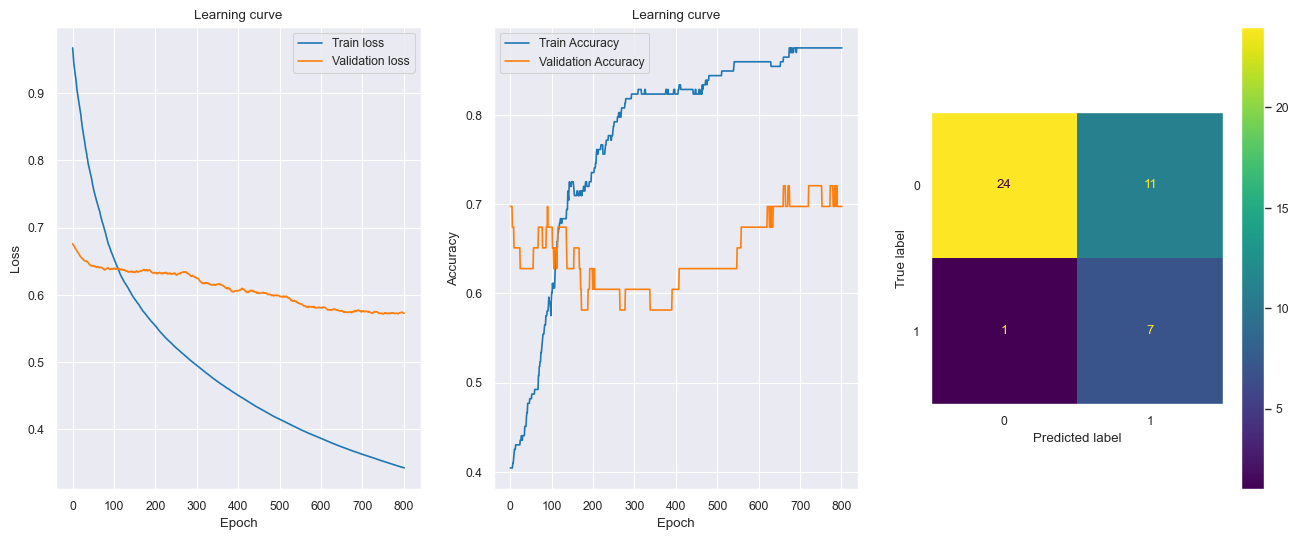

Fold 1 Init 0 Balanced Log Loss: 0.4387
Fold 1 Init 1 Balanced Log Loss: 0.8934
Fold 1 Init 2 Balanced Log Loss: 0.7842
Fold 1 Init 3 Balanced Log Loss: 0.4033
Fold 1 Init 4 Balanced Log Loss: 0.7809
Fold 1 Balanced Log Loss: 0.4033
Fold 1 Accuracy: 72.09%


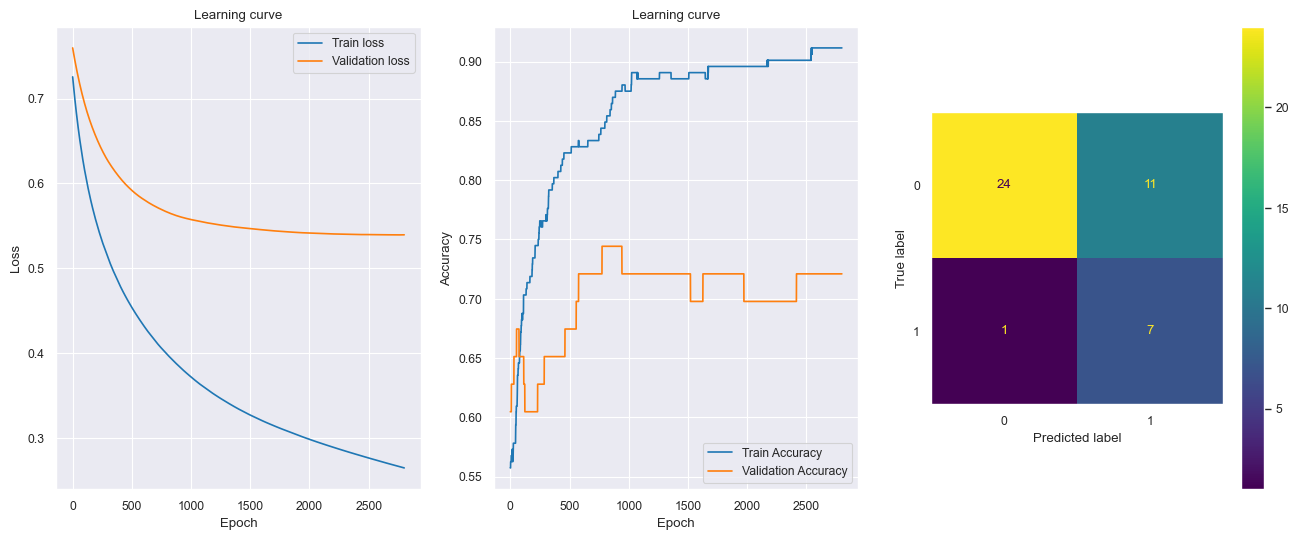

Fold 2 Init 0 Balanced Log Loss: 0.4358
Fold 2 Init 1 Balanced Log Loss: 0.4654
Fold 2 Init 2 Balanced Log Loss: 0.4436
Fold 2 Init 3 Balanced Log Loss: 0.8506
Fold 2 Init 4 Balanced Log Loss: 0.4737
Fold 2 Balanced Log Loss: 0.4358
Fold 2 Accuracy: 81.40%


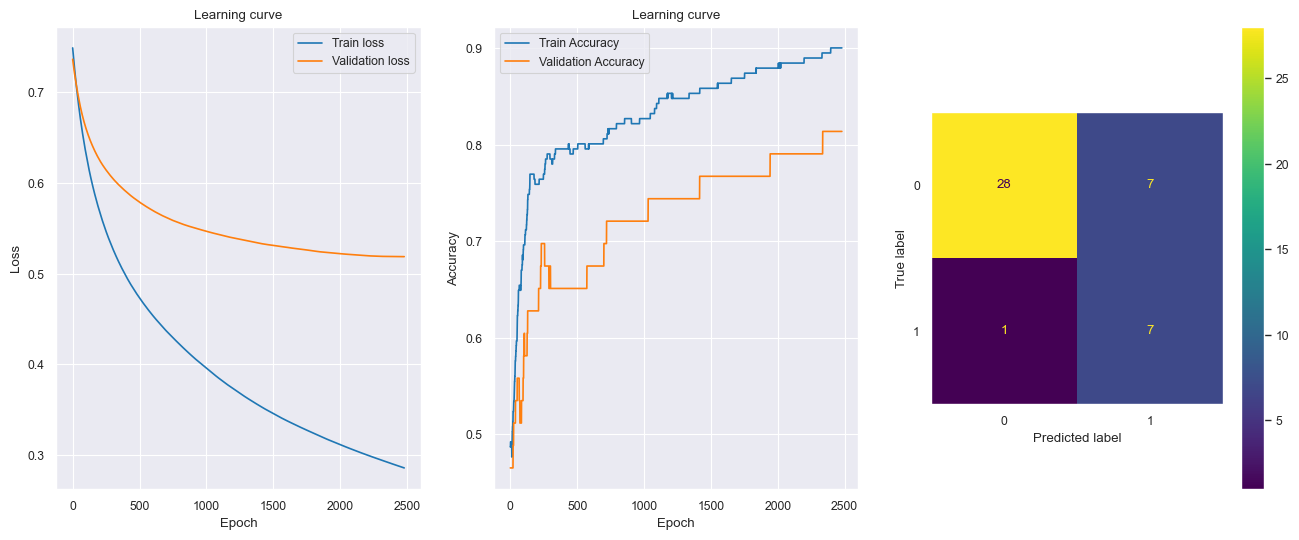

Fold 3 Init 0 Balanced Log Loss: 0.5304
Fold 3 Init 1 Balanced Log Loss: 0.5803
Fold 3 Init 2 Balanced Log Loss: 0.8226
Fold 3 Init 3 Balanced Log Loss: 0.6738
Fold 3 Init 4 Balanced Log Loss: 0.5395
Fold 3 Balanced Log Loss: 0.5304
Fold 3 Accuracy: 74.42%


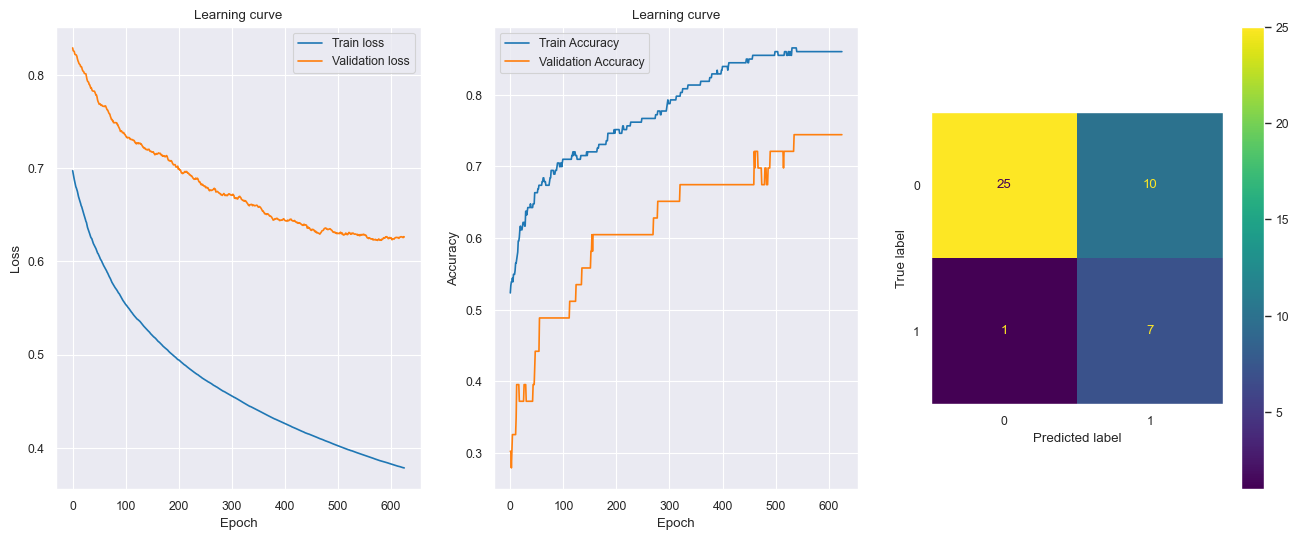

Fold 4 Init 0 Balanced Log Loss: 0.5168
Fold 4 Init 1 Balanced Log Loss: 0.5595
Fold 4 Init 2 Balanced Log Loss: 0.5382
Fold 4 Init 3 Balanced Log Loss: 0.5111
Fold 4 Init 4 Balanced Log Loss: 0.7149
Fold 4 Balanced Log Loss: 0.5111
Fold 4 Accuracy: 67.44%


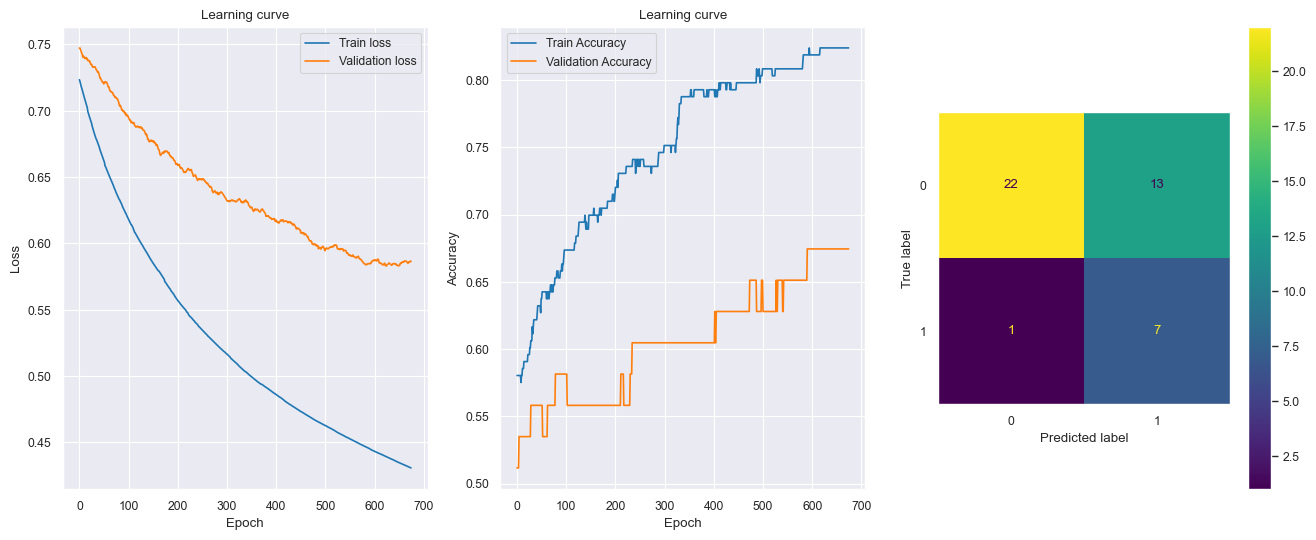

Best Fold: 1
Best Balanced Log Loss: 0.4033024238904805


In [47]:
cv = ShuffleSplit(n_splits=5, train_size=0.21, random_state=random_state)

X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=0.07, random_state=random_state, stratify=y)

# Separate classes for balanced cross validation
y_train_0 = y_train_cv[y_train_cv == 0]
y_train_1 = y_train_cv[y_train_cv == 1]
X_train_0 = X_train_cv.loc[y_train_0.index]
X_train_1 = X_train_cv.loc[y_train_1.index]

cv_data = []
best_score = 100
best_fold = None
best_model = None
for fold, (train_i, val_i) in enumerate(cv.split(X_train_0, y_train_0)):
    # Check if folds are not overlapping
    assert len(set(train_i) & set(val_i)) == 0

    # Copy test set for each fold
    X_test_fold, y_test_fold = X_test.copy(), y_test.copy()

    # Prepare train set
    X_train, y_train = X_train_0.iloc[train_i], y_train_0.iloc[train_i]

    # Add class 1 to train set
    X_train, y_train = pd.concat([X_train, X_train_1]), pd.concat([y_train, y_train_1])

    # Shuffle train set
    X_train, y_train = shuffle(X_train, y_train, random_state=random_state)

    # Impute missing values
    knn_imputer = KNNImputer(n_neighbors=5)
    X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_fold = pd.DataFrame(knn_imputer.transform(X_test_fold), columns=X_test_fold.columns, index=X_test_fold.index)

    # Remove outliers
    X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

    # Scale features
    scaler = LogScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_fold = pd.DataFrame(scaler.transform(X_test_fold), columns=X_test_fold.columns, index=X_test_fold.index)

    # PCA
    pca = PCA(n_components=0.85, random_state=random_state)
    X_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
    X_test_fold = pd.DataFrame(pca.transform(X_test_fold), index=X_test_fold.index)
    
    # Multiple initializations
    n_init = 5

    init_best_score = 100
    history = None
    init_best_model = None
    for init in range(n_init):
        # Neural Network Architecture
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile Neural Network
        opt = SGD(learning_rate=0.001)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

        # Train Neural Network
        h = model.fit(X_train, y_train, epochs=10000, batch_size=32, callbacks=es, verbose=0, validation_data=(X_test_fold, y_test_fold))

        # Evaluate Initializations
        y_score = model.predict(X_test_fold, verbose=0)
        score = balanced_logloss(y_test_fold, y_score)
        print(f'Fold {fold} Init {init} Balanced Log Loss: {score :.4f}')

        # Save best initialization
        if score < init_best_score:
            init_best_score = score
            init_best_model = model
            history = h
    
    # Evaluate Neural Network
    y_score = init_best_model.predict(X_test_fold, verbose=0)
    score = balanced_logloss(y_test_fold, y_score)
    print(f'Fold {fold} Balanced Log Loss: {score :.4f}')
    accuracy = accuracy_score(y_test_fold, np.where(y_score > 0.5, 1, 0))
    print(f'Fold {fold} Accuracy: {accuracy * 100 :.2f}%')

    # Save data for plotting
    cv_data.append({
        'label_encoder' : le,
        'knn_imputer' : knn_imputer,
        'scaler' : scaler,
        'pca' : pca,
        'model' : init_best_model
    })

    # Save best model
    if score < best_score:
        best_score = score
        best_fold = fold
        best_model = init_best_model

    # Plot learning curves
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))

    plt.subplot(131)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(132)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot confusion matrix
    y_score = np.where(y_score > 0.5, 1, 0)
    cm = confusion_matrix(y_test, y_score)
    ax = plt.subplot(133)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    plt.grid(False)
    plt.show()

# Print best model
print(f'Best Fold: {best_fold}')
print(f'Best Balanced Log Loss: {best_score}')

In [50]:
cv_data[best_fold]

{'label_encoder': LabelEncoder(),
 'knn_imputer': KNNImputer(),
 'scaler': <__main__.LogScaler at 0x291d1bee0>,
 'pca': PCA(n_components=0.85, random_state=42),
 'model': <keras.engine.sequential.Sequential at 0x294d15c90>}

In [52]:
test_scaled = pd.DataFrame(cv_data[best_fold]['scaler'].transform(test), columns=test.columns, index=test.index)
test_pca = pd.DataFrame(cv_data[best_fold]['pca'].transform(test_scaled), index=test_scaled.index)
test_pred = cv_data[best_fold]['model'].predict(test_pca, verbose=0)
test_pred

array([[0.43654394],
       [0.43654394],
       [0.43654394],
       [0.43654394],
       [0.43654394]], dtype=float32)

Fold 0 Init 0 Balanced Log Loss: 0.3372
Fold 0 Init 1 Balanced Log Loss: 0.3478
Fold 0 Init 2 Balanced Log Loss: 0.3017
Fold 0 Init 3 Balanced Log Loss: 0.2994
Fold 0 Init 4 Balanced Log Loss: 0.3800
Fold 0 Balanced Log Loss: 0.2994
Fold 0 Accuracy: 83.72%


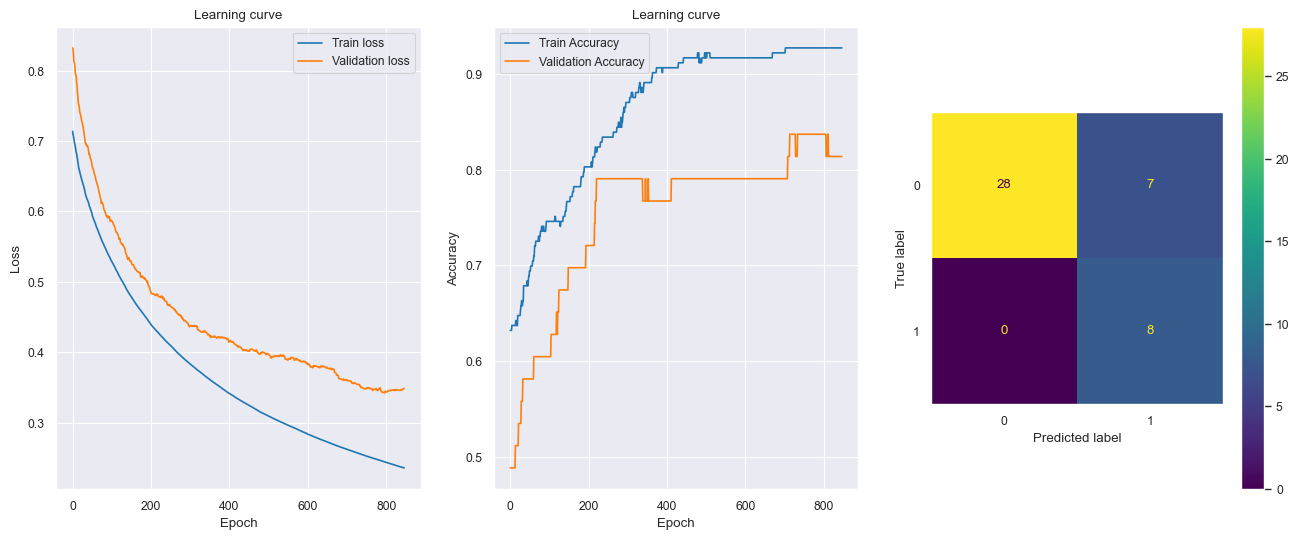

Fold 1 Init 0 Balanced Log Loss: 0.2828
Fold 1 Init 1 Balanced Log Loss: 0.3042
Fold 1 Init 2 Balanced Log Loss: 0.2556
Fold 1 Init 3 Balanced Log Loss: 0.2535
Fold 1 Init 4 Balanced Log Loss: 0.3106
Fold 1 Balanced Log Loss: 0.2535
Fold 1 Accuracy: 86.05%


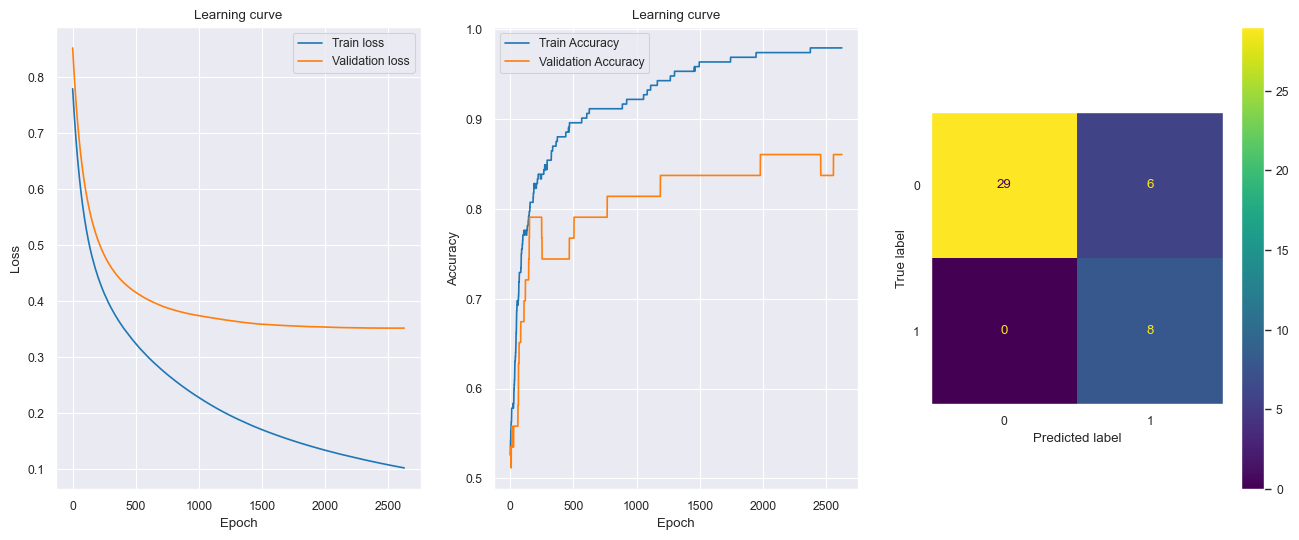

Fold 2 Init 0 Balanced Log Loss: 0.2667
Fold 2 Init 1 Balanced Log Loss: 0.3297
Fold 2 Init 2 Balanced Log Loss: 0.3081
Fold 2 Init 3 Balanced Log Loss: 0.2581
Fold 2 Init 4 Balanced Log Loss: 0.3739
Fold 2 Balanced Log Loss: 0.2581
Fold 2 Accuracy: 88.37%


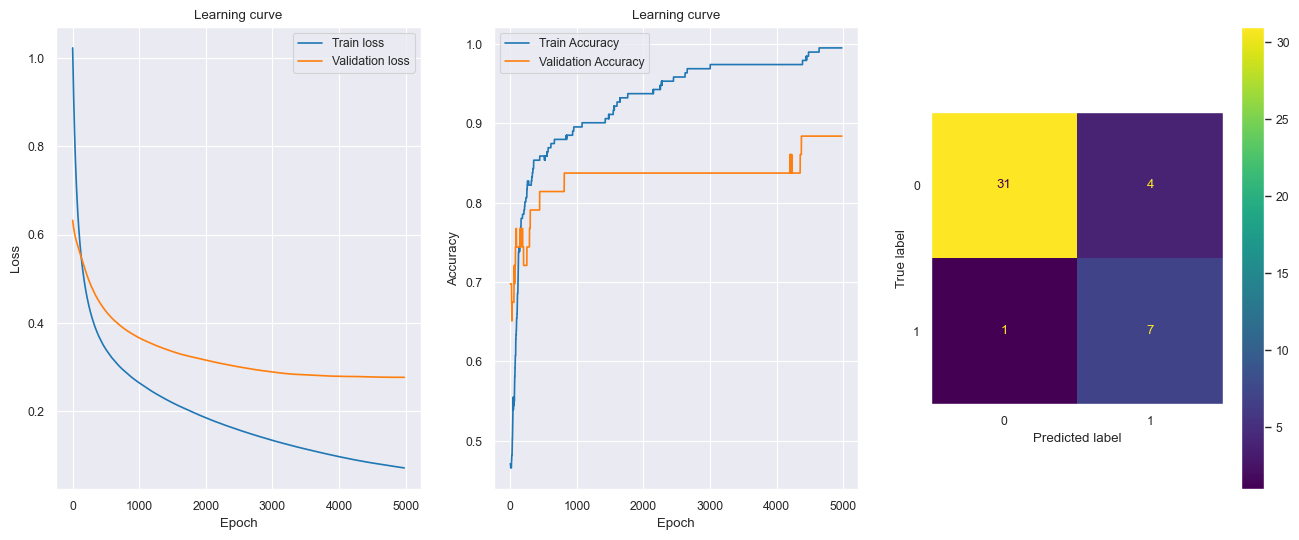

Fold 3 Init 0 Balanced Log Loss: 0.3808
Fold 3 Init 1 Balanced Log Loss: 0.4259
Fold 3 Init 2 Balanced Log Loss: 0.3202
Fold 3 Init 3 Balanced Log Loss: 0.3246
Fold 3 Init 4 Balanced Log Loss: 0.5744
Fold 3 Balanced Log Loss: 0.3202
Fold 3 Accuracy: 88.37%


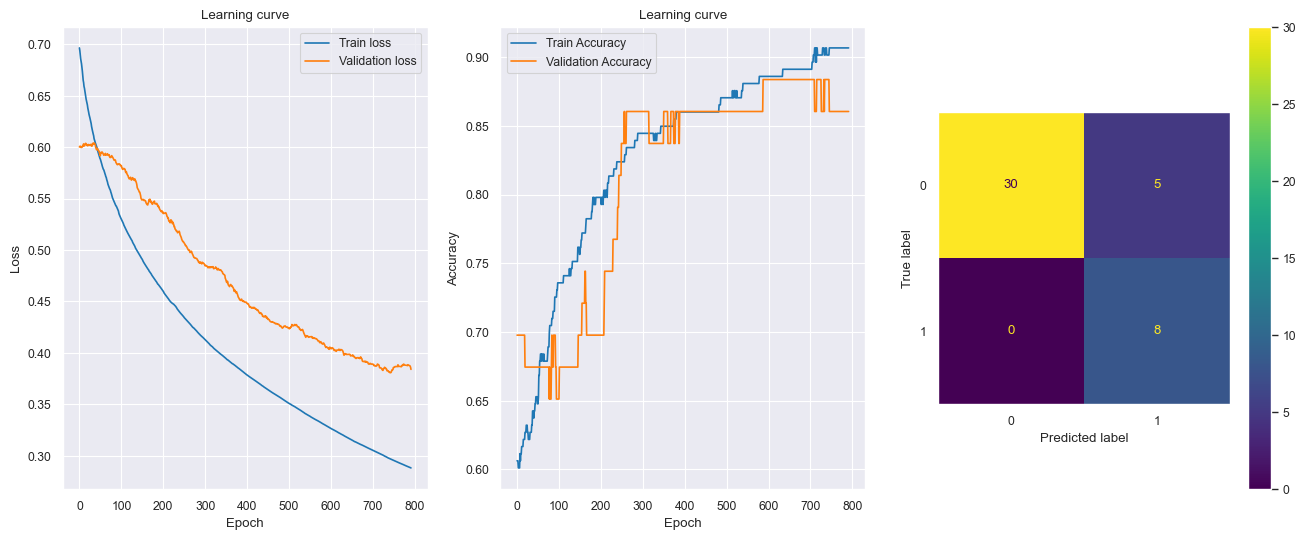

Fold 4 Init 0 Balanced Log Loss: 0.2823
Fold 4 Init 1 Balanced Log Loss: 0.3658
Fold 4 Init 2 Balanced Log Loss: 0.3153
Fold 4 Init 3 Balanced Log Loss: 0.7612
Fold 4 Init 4 Balanced Log Loss: 0.3177
Fold 4 Balanced Log Loss: 0.2823
Fold 4 Accuracy: 88.37%


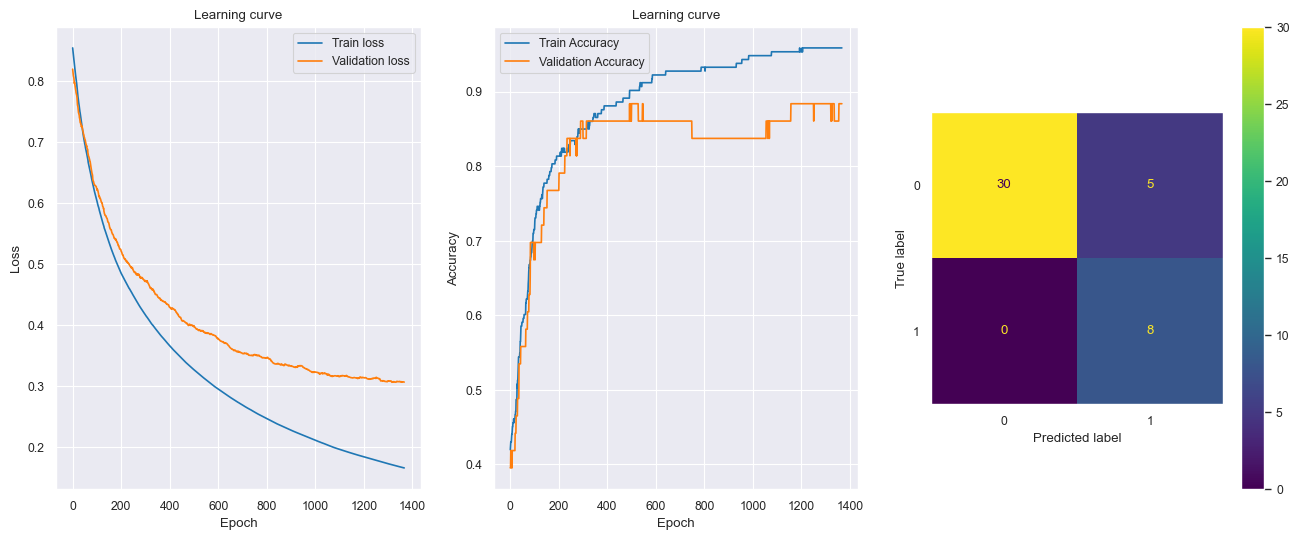

Best Fold: 1
Best Balanced Log Loss: 0.253480313181847


In [56]:
cv = ShuffleSplit(n_splits=5, train_size=0.21, random_state=random_state)

X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=0.07, random_state=random_state, stratify=y)

# Separate classes for balanced cross validation
y_train_0 = y_train_cv[y_train_cv == 0]
y_train_1 = y_train_cv[y_train_cv == 1]
X_train_0 = X_train_cv.loc[y_train_0.index]
X_train_1 = X_train_cv.loc[y_train_1.index]

cv_data = []
best_score = 100
best_fold = None
best_model = None
for fold, (train_i, val_i) in enumerate(cv.split(X_train_0, y_train_0)):
    # Check if folds are not overlapping
    assert len(set(train_i) & set(val_i)) == 0

    # Copy test set for each fold
    X_test_fold, y_test_fold = X_test.copy(), y_test.copy()

    # Prepare train set
    X_train, y_train = X_train_0.iloc[train_i], y_train_0.iloc[train_i]

    # Add class 1 to train set
    X_train, y_train = pd.concat([X_train, X_train_1]), pd.concat([y_train, y_train_1])

    # Shuffle train set
    X_train, y_train = shuffle(X_train, y_train, random_state=random_state)

    # Impute missing values
    knn_imputer = KNNImputer(n_neighbors=5)
    X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_fold = pd.DataFrame(knn_imputer.transform(X_test_fold), columns=X_test_fold.columns, index=X_test_fold.index)

    # Remove outliers
    X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

    # Scale features
    scaler = PowerTransformer() #! CHANGED SCALER
    X_train = scaler.fit_transform(X_train)
    X_test_fold = scaler.transform(X_test_fold)

    # PCA
    pca = PCA(n_components=0.85, random_state=random_state)
    X_train = pca.fit_transform(X_train)
    X_test_fold = pca.transform(X_test_fold)
    
    # Multiple initializations
    n_init = 5

    init_best_score = 100
    history = None
    init_best_model = None
    for init in range(n_init):
        # Neural Network Architecture
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile Neural Network
        opt = SGD(learning_rate=0.001)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

        # Train Neural Network
        h = model.fit(X_train, y_train, epochs=10000, batch_size=32, callbacks=es, verbose=0, validation_data=(X_test_fold, y_test_fold))

        # Evaluate Initializations
        y_score = model.predict(X_test_fold, verbose=0)
        score = balanced_logloss(y_test_fold, y_score)
        print(f'Fold {fold} Init {init} Balanced Log Loss: {score :.4f}')

        # Save best initialization
        if score < init_best_score:
            init_best_score = score
            init_best_model = model
            history = h
    
    # Evaluate Neural Network
    y_score = init_best_model.predict(X_test_fold, verbose=0)
    score = balanced_logloss(y_test_fold, y_score)
    print(f'Fold {fold} Balanced Log Loss: {score :.4f}')
    accuracy = accuracy_score(y_test_fold, np.where(y_score > 0.5, 1, 0))
    print(f'Fold {fold} Accuracy: {accuracy * 100 :.2f}%')

    # Save data for plotting
    cv_data.append({
        'label_encoder' : le,
        'knn_imputer' : knn_imputer,
        'scaler' : scaler,
        'pca' : pca,
        'model' : init_best_model
    })

    # Save best model
    if score < best_score:
        best_score = score
        best_fold = fold
        best_model = init_best_model

    # Plot learning curves
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))

    plt.subplot(131)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(132)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot confusion matrix
    y_score = np.where(y_score > 0.5, 1, 0)
    cm = confusion_matrix(y_test, y_score)
    ax = plt.subplot(133)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    plt.grid(False)
    plt.show()

# Print best model
print(f'Best Fold: {best_fold}')
print(f'Best Balanced Log Loss: {best_score}')

Fold 0 Init 0 Balanced Log Loss: 0.2314
Fold 0 Init 1 Balanced Log Loss: 0.7335
Fold 0 Init 2 Balanced Log Loss: 0.3260
Fold 0 Init 3 Balanced Log Loss: 0.2530
Fold 0 Init 4 Balanced Log Loss: 0.3669
Fold 0 Balanced Log Loss: 0.2314
Fold 0 Accuracy: 88.37%


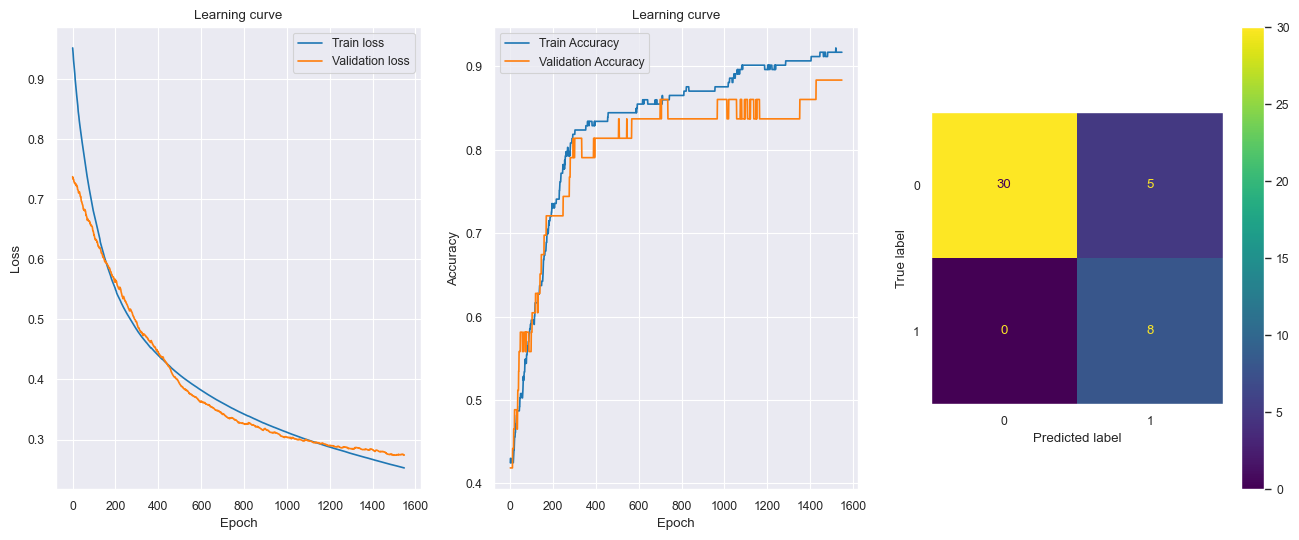

Fold 1 Init 0 Balanced Log Loss: 0.3990
Fold 1 Init 1 Balanced Log Loss: 0.3129
Fold 1 Init 2 Balanced Log Loss: 0.4041
Fold 1 Init 3 Balanced Log Loss: 0.6573
Fold 1 Init 4 Balanced Log Loss: 0.3311
Fold 1 Balanced Log Loss: 0.3129
Fold 1 Accuracy: 83.72%


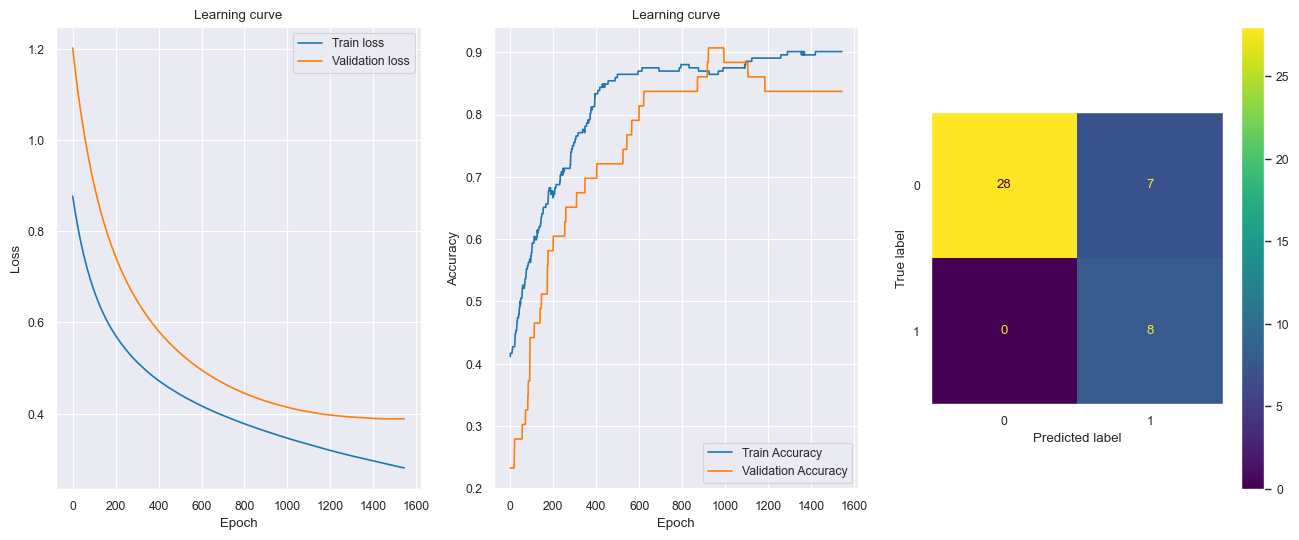

Fold 2 Init 0 Balanced Log Loss: 0.2692
Fold 2 Init 1 Balanced Log Loss: 0.2810
Fold 2 Init 2 Balanced Log Loss: 0.3681
Fold 2 Init 3 Balanced Log Loss: 0.3617
Fold 2 Init 4 Balanced Log Loss: 0.3273
Fold 2 Balanced Log Loss: 0.2692
Fold 2 Accuracy: 88.37%


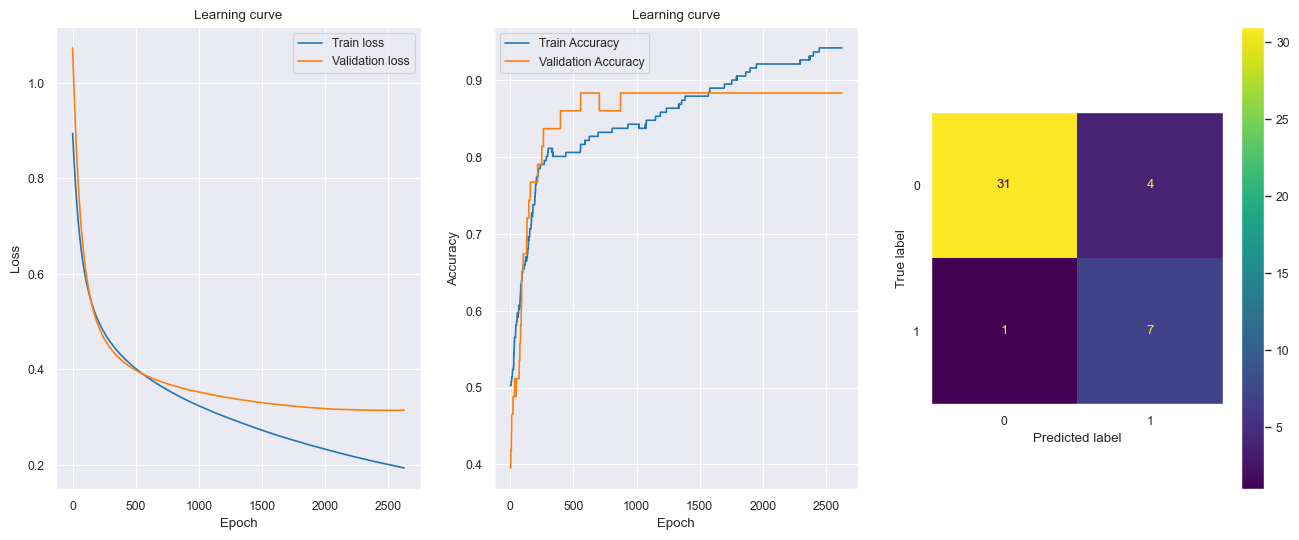

Fold 3 Init 0 Balanced Log Loss: 0.2931
Fold 3 Init 1 Balanced Log Loss: 0.4993
Fold 3 Init 2 Balanced Log Loss: 0.7387
Fold 3 Init 3 Balanced Log Loss: 0.2527
Fold 3 Init 4 Balanced Log Loss: 0.3320
Fold 3 Balanced Log Loss: 0.2527
Fold 3 Accuracy: 90.70%


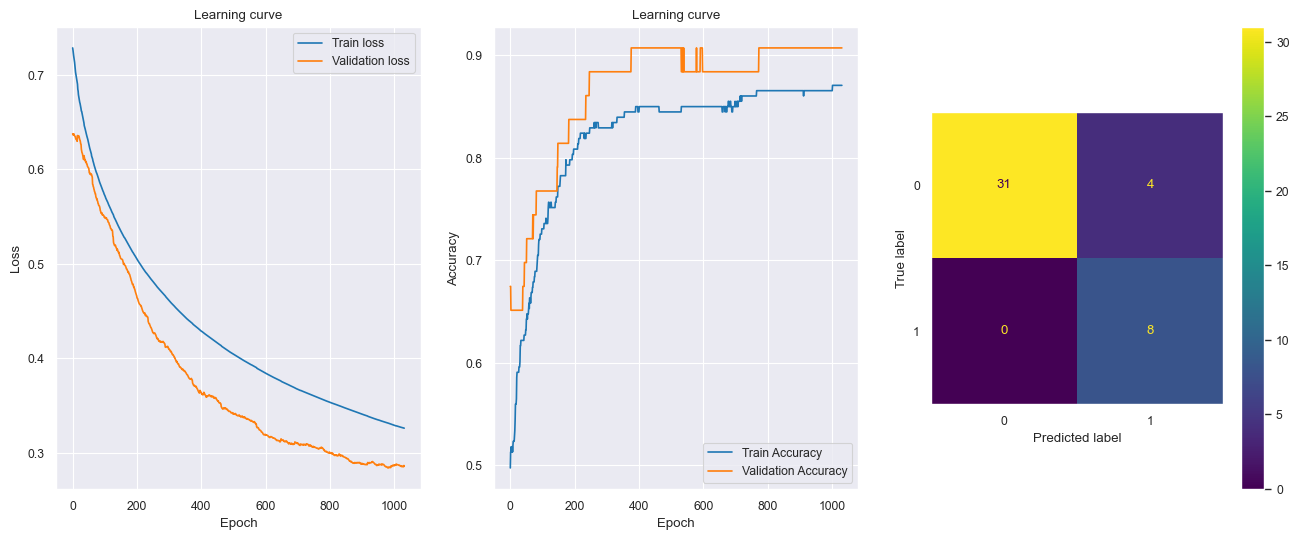

Fold 4 Init 0 Balanced Log Loss: 0.2839
Fold 4 Init 1 Balanced Log Loss: 0.2447
Fold 4 Init 2 Balanced Log Loss: 0.2545
Fold 4 Init 3 Balanced Log Loss: 0.2512
Fold 4 Init 4 Balanced Log Loss: 0.2941
Fold 4 Balanced Log Loss: 0.2447
Fold 4 Accuracy: 100.00%


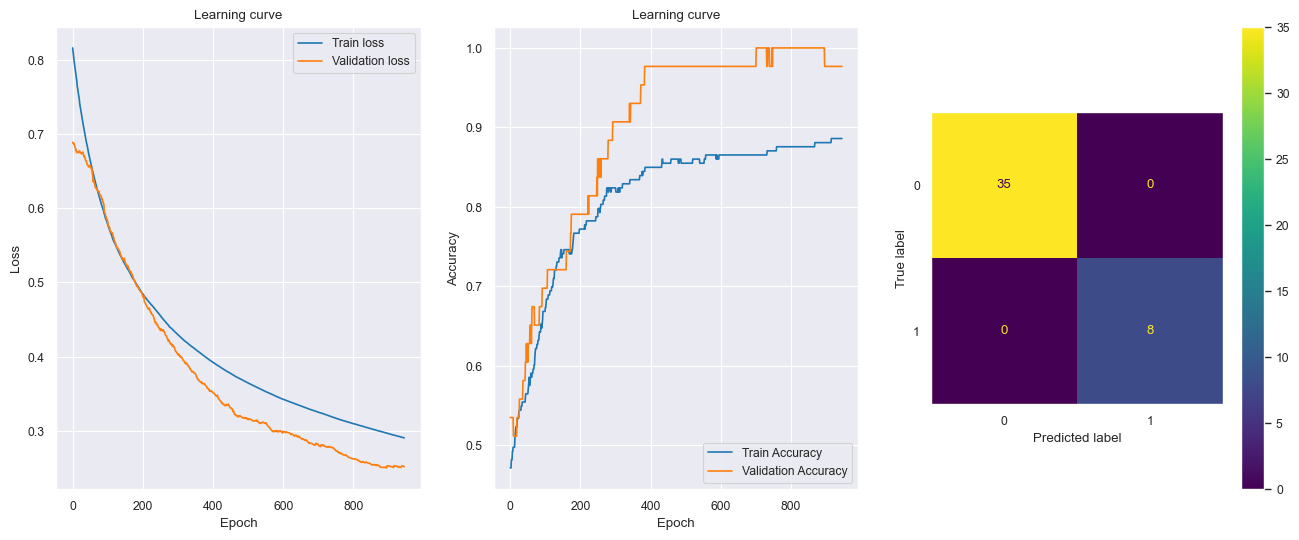

Best Fold: 0
Best Balanced Log Loss: 0.23140498401459939


In [60]:
cv = ShuffleSplit(n_splits=5, train_size=0.21, random_state=random_state)

X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=0.07, random_state=random_state, stratify=y)

# Separate classes for balanced cross validation
y_train_0 = y_train_cv[y_train_cv == 0]
y_train_1 = y_train_cv[y_train_cv == 1]
X_train_0 = X_train_cv.loc[y_train_0.index]
X_train_1 = X_train_cv.loc[y_train_1.index]

cv_data = []
best_score = 100
best_fold = None
best_model = None
for fold, (train_i, val_i) in enumerate(cv.split(X_train_0, y_train_0)):
    # Check if folds are not overlapping
    assert len(set(train_i) & set(val_i)) == 0

    # Copy test set for each fold
    X_test_fold, y_test_fold = X_test.copy(), y_test.copy()

    # Prepare train set
    X_train, y_train = X_train_0.iloc[train_i], y_train_0.iloc[train_i]

    # Add class 1 to train set
    X_train, y_train = pd.concat([X_train, X_train_1]), pd.concat([y_train, y_train_1])

    # Shuffle train set
    X_train, y_train = shuffle(X_train, y_train, random_state=random_state)

    # Impute missing values
    knn_imputer = KNNImputer(n_neighbors=5)
    X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_fold = pd.DataFrame(knn_imputer.transform(X_test_fold), columns=X_test_fold.columns, index=X_test_fold.index)

    # Remove outliers
    X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

    # Scale features
    scaler = StandardScaler() #! CHANGED SCALER
    X_train = scaler.fit_transform(X_train)
    X_test_fold = scaler.transform(X_test_fold)

    # PCA
    pca = PCA(n_components=0.85, random_state=random_state)
    X_train = pca.fit_transform(X_train)
    X_test_fold = pca.transform(X_test_fold)
    
    # Multiple initializations
    n_init = 5

    init_best_score = 100
    history = None
    init_best_model = None
    for init in range(n_init):
        # Neural Network Architecture
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile Neural Network
        opt = SGD(learning_rate=0.001)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

        # Train Neural Network
        h = model.fit(X_train, y_train, epochs=10000, batch_size=32, callbacks=es, verbose=0, validation_data=(X_test_fold, y_test_fold))

        # Evaluate Initializations
        y_score = model.predict(X_test_fold, verbose=0)
        score = balanced_logloss(y_test_fold, y_score)
        print(f'Fold {fold} Init {init} Balanced Log Loss: {score :.4f}')

        # Save best initialization
        if score < init_best_score:
            init_best_score = score
            init_best_model = model
            history = h
    
    # Evaluate Neural Network
    y_score = init_best_model.predict(X_test_fold, verbose=0)
    score = balanced_logloss(y_test_fold, y_score)
    print(f'Fold {fold} Balanced Log Loss: {score :.4f}')
    accuracy = accuracy_score(y_test_fold, np.where(y_score > 0.5, 1, 0))
    print(f'Fold {fold} Accuracy: {accuracy * 100 :.2f}%')

    # Save data for plotting
    cv_data.append({
        'label_encoder' : le,
        'knn_imputer' : knn_imputer,
        'scaler' : scaler,
        'pca' : pca,
        'model' : init_best_model
    })

    # Save best model
    if score < best_score:
        best_score = score
        best_fold = fold
        best_model = init_best_model

    # Plot learning curves
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))

    plt.subplot(131)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(132)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot confusion matrix
    y_score = np.where(y_score > 0.5, 1, 0)
    cm = confusion_matrix(y_test, y_score)
    ax = plt.subplot(133)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    plt.grid(False)
    plt.show()

# Print best model
print(f'Best Fold: {best_fold}')
print(f'Best Balanced Log Loss: {best_score}')

## Evaluation

In [61]:
cv_data[best_fold]

{'label_encoder': LabelEncoder(),
 'knn_imputer': KNNImputer(),
 'scaler': StandardScaler(),
 'pca': PCA(n_components=0.85, random_state=42),
 'model': <keras.engine.sequential.Sequential at 0x284c6f9d0>}

In [62]:
test_scaled = cv_data[best_fold]['scaler'].transform(test)
test_pca = cv_data[best_fold]['pca'].transform(test_scaled)
test_pred = cv_data[best_fold]['model'].predict(test_pca, verbose=0)
test_pred

array([[0.00830924],
       [0.00830924],
       [0.00830924],
       [0.00830924],
       [0.00830923]], dtype=float32)